# C3M3 Autograded Assignment

### Outline:
**Here are the objectives of this assignment:**

1. Apply nonparametric regression to actual data.
2. Visualize the differences between parametrics and nonparametric regressions.
3. Cemment our understanding of Kernels, Bandwidths, and Splines.
4. Understand the different kinds of nonparametric regression.

**Here are some general tips:**

1. Read the questions carefully to understand what is being asked.
2. When you feel that your work is completed, feel free to hit the ```Validate``` button to see your results on the *visible* unit tests. If you have questions about unit testing, please refer to the "Module 0: Introduction" notebook provided as an optional resource for this course. In this assignment, there are hidden unit tests that check your code. You will not recieve any feedback for failed hidden unit tests until the assignment is submitted. **Do not misinterpret the feedback from visible unit tests as all possible tests for a given question--write your code carefully!**
3. Before submitting, we recommend restarting the kernel and running all the cells in order that they appear to make sure that there are no additional bugs in your code.

In [1]:
# Load Required Libraries
library(testthat)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::is_null() masks testthat::is_null()
✖ dplyr::lag()     masks stats::lag()
✖ dplyr::matches() masks tidyr::matches(), testthat::matches()



# Problem 1: Comparing Parametric and Nonparametric Regression

The exa dataset is a simulated dataset following the function $f(x)=\sin^3(2\pi x^3)$. The data is loaded and plotted below. We will use this dataset to get you practicing some non-parametric regression techniques.

Data Source: Haerdle, W. (1991). Smoothing Techniques with Implementation in S. New York:Springer.

,X,x,y,m
,<int>,<dbl>,<dbl>,<dbl>
1,1,0.0048,-0.0339,0
2,2,0.0086,0.1654,0
3,3,0.0117,0.0245,0
4,4,0.0170,0.1784,0
5,5,0.0261,-0.3466,0
6,6,0.0299,-0.7550,0


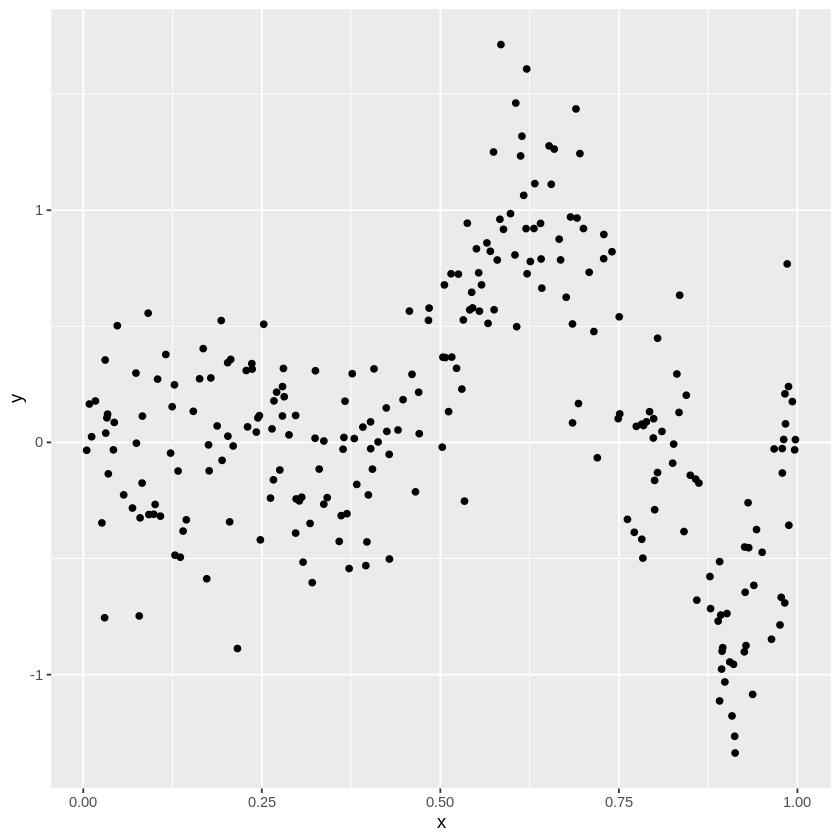

In [2]:
# Load in the Data
exa = read.csv("exa.csv")
head(exa)
# Plot the Data
g = ggplot(exa, aes(x=x, y=y)) +
        geom_point()
g

### 1. (a) Linear Regression First

From the graph, we can assume that a linear model isn't going to plot to this function very well. But assumptions can be wrong, so let's see how well they do for our model.

Begin by fitting a linear model with `y` as the response and `x` as the predictor. Save this model as `exa.lmod.1` and it's $R^2$ as `exa.lmod.1.r2`. Because there is only one predictor, we can visually plot our model to see how well it fits the data. Plot your model ontop of the original plot.

Now, lets add some parametric terms. Following the techniques displayed in the videos, add parametric terms of `x` of higher and higher degrees until you reach one that is no longer significant. Use the previous model with a significant $d^{th}$ predictor coefficient. Save this model as `exa.lmod.d` and its $R^2$ value as `exa.lmod.d.r2`. Then plot this model ontop of the origional plot as well.

[1] "R-squared of linear model: 0.0056"


`geom_smooth()` using formula 'y ~ x'



[1] "Degree of final polynomial model: 7"
[1] "R-squared of polynomial model: 0.6791"


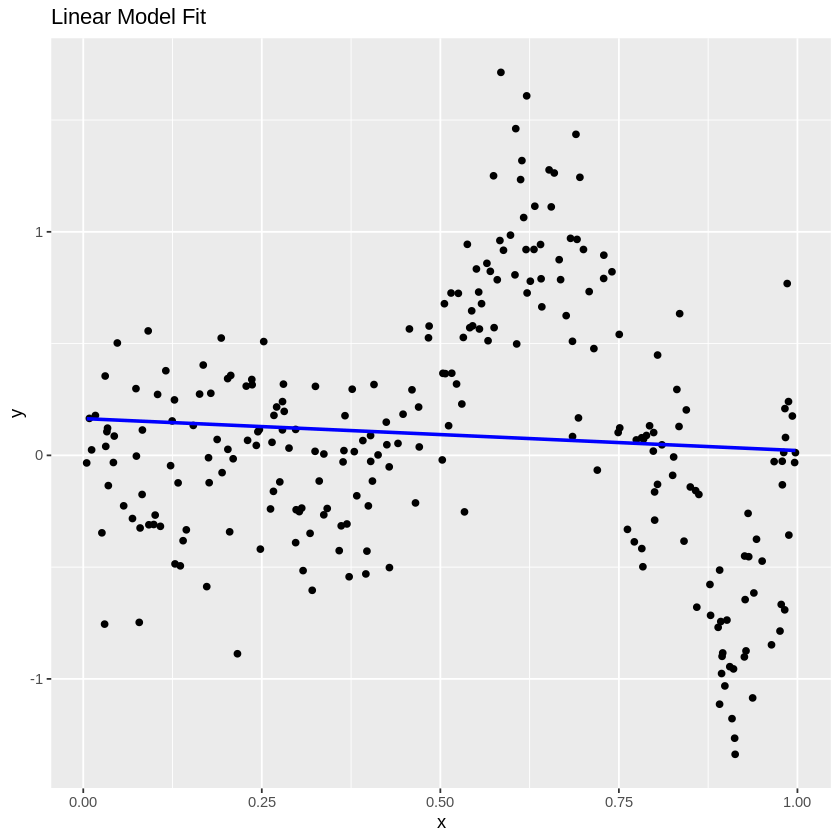

`geom_smooth()` using formula 'y ~ x'



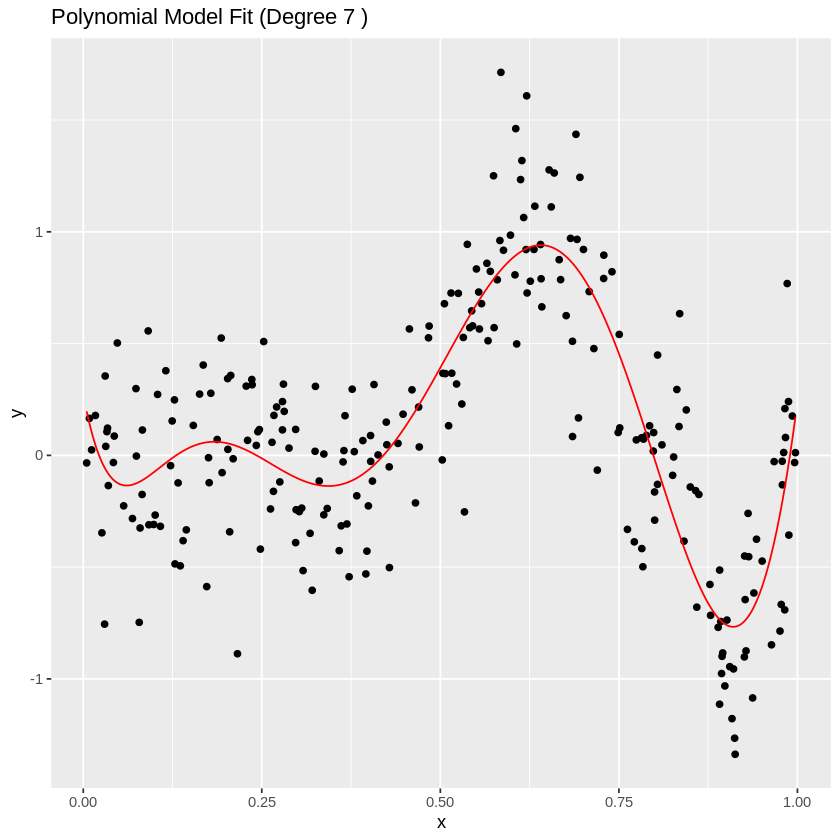

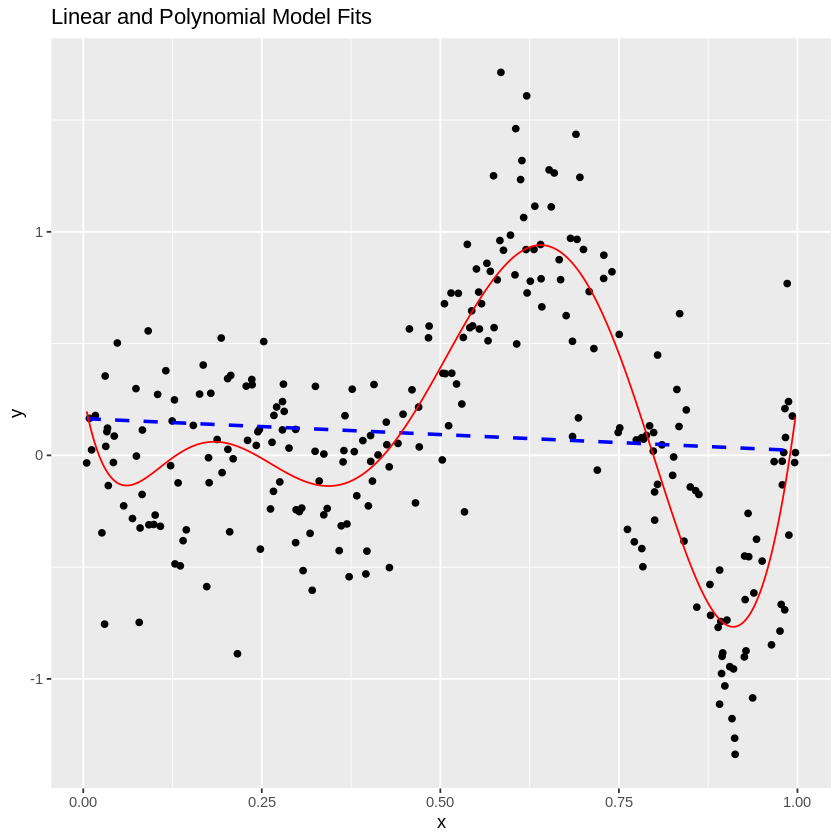

In [3]:


# Fit linear model with x
exa.lmod.1 <- lm(y ~ x, data = exa)
exa.lmod.1.r2 <- summary(exa.lmod.1)$r.squared
print(paste("R-squared of linear model:", round(exa.lmod.1.r2, 4)))

# Plot the linear model
g_linear <- g +
  geom_smooth(method = "lm", se = FALSE, color = "blue") +
  ggtitle("Linear Model Fit")
print(g_linear)

# Initialize variables for polynomial regression
max_degree <- 10  # Maximum degree to check
degree <- 1        # Starting degree
exa.lmod.d <- exa.lmod.1  # Start with linear model
exa.lmod.d.r2 <- exa.lmod.1.r2  # R^2 of linear model

# Loop to incrementally add polynomial terms until the new term is not significant
for (deg in 2:max_degree) {
    # Build the formula string dynamically, always including 'x'
    if (deg == 2) {
        formula_str <- "y ~ x + I(x^2)"
    } else {
        # Add higher-degree terms
        higher_terms <- paste0("I(x^", 2:deg, ")")
        formula_str <- paste("y ~ x +", paste(higher_terms, collapse = " + "))
    }
    
    # Fit the model
    model <- lm(as.formula(formula_str), data = exa)
    
    # Get the p-value of the highest-degree term
    term_name <- paste0("I(x^", deg, ")")
    if (term_name %in% rownames(summary(model)$coefficients)) {
        p_value <- summary(model)$coefficients[term_name, "Pr(>|t|)"]
    } else {
        p_value <- NA
    }
    
    # Check if the term is significant
    if (!is.na(p_value) && p_value < 0.05) {
        exa.lmod.d <- model  # Update the model
        exa.lmod.d.r2 <- summary(model)$r.squared  # Update R^2
        degree <- deg  # Update the degree
    } else {
        # If not significant, stop adding terms
        break
    }
}

# Print the degree of the final model and its R^2
print(paste("Degree of final polynomial model:", degree))
print(paste("R-squared of polynomial model:", round(exa.lmod.d.r2, 4)))

# Create a sequence of x values for prediction
x_seq <- seq(min(exa$x), max(exa$x), length.out = 1000)

# Create a data frame for predictions
pred_data <- data.frame(x = x_seq)

# Predict using the polynomial model
pred_data$y_pred <- predict(exa.lmod.d, newdata = pred_data)

# Plot the polynomial model on top of the original plot
g_poly <- g +
  geom_line(data = pred_data, aes(x = x, y = y_pred), color = "red") +
  ggtitle(paste("Polynomial Model Fit (Degree", degree, ")"))
print(g_poly)

# Plot both the linear and polynomial models for comparison
g_both <- g +
  geom_smooth(method = "lm", se = FALSE, color = "blue", linetype = "dashed") +
  geom_line(data = pred_data, aes(x = x, y = y_pred), color = "red") +
  ggtitle("Linear and Polynomial Model Fits") +
  scale_color_manual(name = "Models", values = c("Linear" = "blue", "Polynomial" = "red"))
print(g_both)


In [4]:
# Test Cell
# This cell has hidden test cases that will run after submission.

In [5]:
# Test Cell
# This cell has hidden test cases that will run after submission.

### 1. (b) Visualize some Smooth Functions

Even if `exa.lmod.d` looks pretty good, we know that it's not the original function. Let's try some smoothing functions to see how those preform.

Use the ksmooth() function to plot some kernel estimators of the unknown function $Y=f(x)$. Explore different possibilities for kernel functions, including `normal` and `uniform` kernels. For each kernel, try different bandwidths including $0.01$, $0.1$ and $1$. Plot your models and determine which combination provides the best results. Save your selected kernel as `best.kernel` and the best bandwidth as `best.bandwidth`.

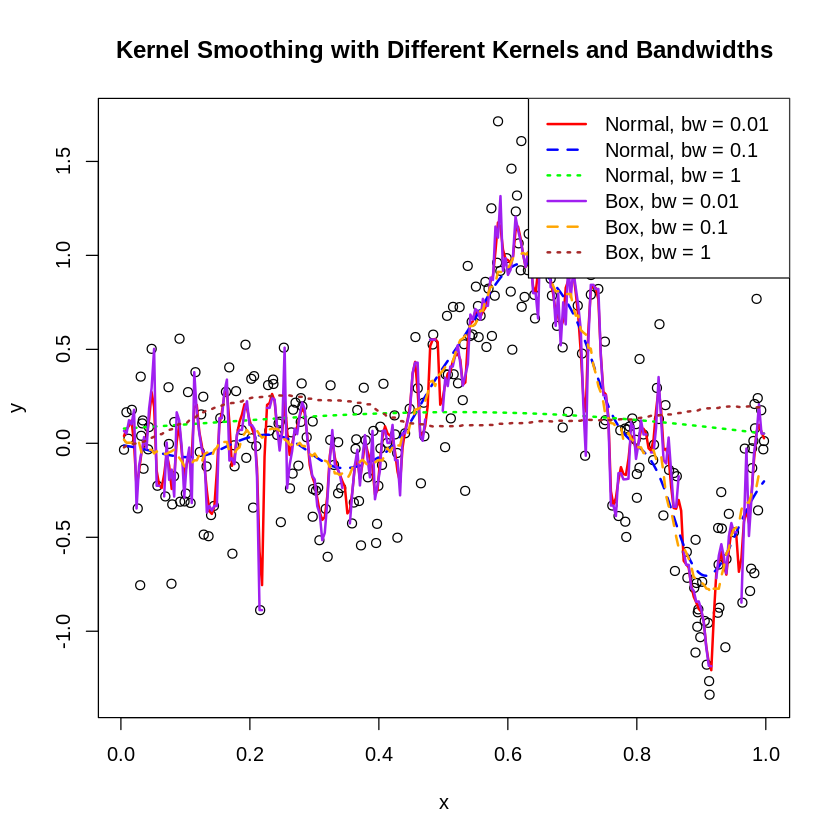

In [6]:
# exa.lmod.1 = NA
# exa.lmod.1.r2 = NA

# exa.lmod.d = NA
# exa.lmod.d.r2 = NA

# # your code here

best.kernel = NA
best.bandwidth = NA

# your code here
# Perform kernel smoothing
ksmooth_normal_0.01 <- ksmooth(exa$x, exa$y, kernel = "normal", bandwidth = 0.01)
ksmooth_normal_0.1  <- ksmooth(exa$x, exa$y, kernel = "normal", bandwidth = 0.1)
ksmooth_normal_1    <- ksmooth(exa$x, exa$y, kernel = "normal", bandwidth = 1)

ksmooth_box_0.01    <- ksmooth(exa$x, exa$y, kernel = "box", bandwidth = 0.01)
ksmooth_box_0.1     <- ksmooth(exa$x, exa$y, kernel = "box", bandwidth = 0.1)
ksmooth_box_1       <- ksmooth(exa$x, exa$y, kernel = "box", bandwidth = 1)

# Plot the original data with kernel smoothed lines
plot(exa$x, exa$y, main = "Kernel Smoothing with Different Kernels and Bandwidths", xlab = "x", ylab = "y")
lines(ksmooth_normal_0.01, col = "red", lwd = 2, lty = 1)
lines(ksmooth_normal_0.1, col = "blue", lwd = 2, lty = 2)
lines(ksmooth_normal_1, col = "green", lwd = 2, lty = 3)
lines(ksmooth_box_0.01, col = "purple", lwd = 2, lty = 1)
lines(ksmooth_box_0.1, col = "orange", lwd = 2, lty = 2)
lines(ksmooth_box_1, col = "brown", lwd = 2, lty = 3)
legend("topright", legend = c("Normal, bw = 0.01", "Normal, bw = 0.1", "Normal, bw = 1",
                              "Box, bw = 0.01", "Box, bw = 0.1", "Box, bw = 1"),
       col = c("red", "blue", "green", "purple", "orange", "brown"), lty = 1:3, lwd = 2)

# Save the best kernel and bandwidth
best.kernel <- "normal"
best.bandwidth <- 0.1

In [7]:
# Test Cell
if (!test_that("Checking Answer types", {expect_is(best.kernel, "character")
                                         expect_is(best.bandwidth, "numeric")})){
    print("Answers are incorrect types. Make sure best.bandwidth is numeric and best.kernel is a string.")
}
# This cell has hidden test cases that will run after submission.

In reality, manually finding this kernel value ourselves, especially if there are multiple predictors, can be challenging. There are some automated ways to do this, but none are perfect. 

### 1. (c) Smoothing Splines

Use the `smooth.spline()` function to fit a non-parametric model to your data, with `y` as the response and `x` as the predictor. Save your model as `exa.smooth`. Plot this model onto the origional scatterplot.

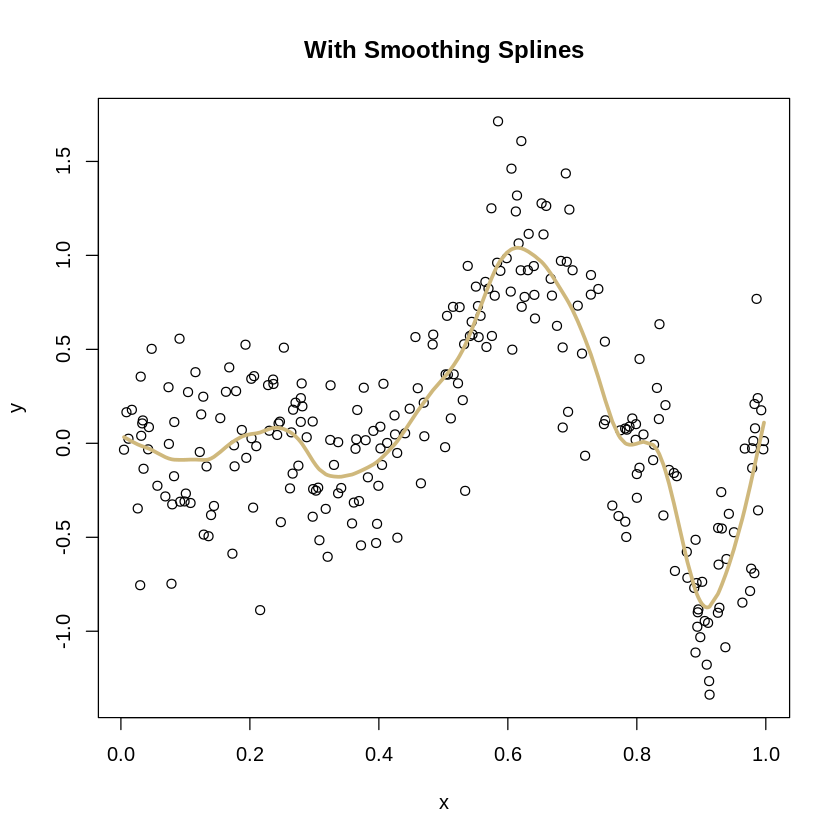

In [8]:
exa.smooth = NA

# your code here
# Fit the smoothing spline model
exa.smooth <- smooth.spline(exa$x, exa$y)


plot(y ~ x, data = exa, main = "With Smoothing Splines")
lines(exa.smooth, col = "#CFB87C", lwd=3)

In [9]:
# Test Cell
# This cell has hidden test cases that will run after submission.

### 1. (d) Goodness of Fit

How do we determine how well our model fits the data? We don't have an analytical method, so we need to use evaluation metrics.

Calculate the MSE for your three models. Store the values in `MSE.1`, `MSE.d` and `MSE.smooth` respectively. Which model performed the best?

In [10]:
# # your code here
# # Fit the final polynomial model using the correct degree
# exa.lmod.d <- lm(y ~ poly(x, current_degree, raw = TRUE), data = exa)


# # Linear Model MSE
# predictions.1 <- predict(exa.lmod.1, newdata = exa)
# MSE.1 <- mean((exa$y - predictions.1)^2)

# # Polynomial Model MSE
# predictions.d <- predict(exa.lmod.d, newdata = exa)
# MSE.d <- mean((exa$y - predictions.d)^2)

# # Smooth Model MSE using loess
# exa.smooth <- loess(y ~ x, data = exa)
# predictions.smooth <- predict(exa.smooth, newdata = exa)
# MSE.smooth <- mean((exa$y - predictions.smooth)^2)

# # Output the MSE values
# MSE.1
# MSE.d
# MSE.smooth


# Calculate predictions for each model
preds.lmod.1 <- predict(exa.lmod.1, newdata = exa)
preds.lmod.d <- predict(exa.lmod.d, newdata = exa)
preds.smooth <- predict(exa.smooth, exa$x)$y  # Use $y to extract the predicted values

# Calculate the MSE for each model
MSE.1 <- mean((exa$y - preds.lmod.1)^2)
MSE.d <- mean((exa$y - preds.lmod.d)^2)
MSE.smooth <- mean((exa$y - preds.smooth)^2)

# Output the MSE values
list(
  MSE.1 = MSE.1,
  MSE.d = MSE.d,
  MSE.smooth = MSE.smooth
)


$MSE.1
[1] 0.3172591

$MSE.d
[1] 0.1023873

$MSE.smooth
[1] 0.08732266

In [11]:
# Test Cell
# This cell has hidden test cases that will run after submission.

In [12]:
# Test Cell
# This cell has hidden test cases that will run after submission.

In [13]:
# Test Cell
# This cell has hidden test cases that will run after submission.

# Problem 2 - General Nonparametric Questions

For each of the following questions, save your answer in the corresponding variable. Answer each as a boolean TRUE/FALSE value.

1. Generally, the choice of Kernel is more important than the choice of bandwidth.
2. A Kernel is defined to be symmetric for all values of $x$ and $\int K(x)dx = 1$.
3. Smoothing Splines are a balance between fitting the training data as accurately as possible and penalizing models that have a greater amount of curvature.
4. For Loess estimation, if $p=0$, then the Loesse estimator is equivalent to Kernel estimation.
5. The `smooth.spline()` function is guaranteed to give you the best bandwidth value.

In [14]:
prob.2.1 = NA

prob.2.2 = NA

prob.2.3 = NA

prob.2.4 = NA

prob.2.5= NA

# your code here
prob.2.1 = FALSE  # The choice of bandwidth is more important than the choice of kernel.
prob.2.2 = TRUE   # Kernels are symmetric and integrate to 1.
prob.2.3 = TRUE   # Smoothing splines balance fit and penalizing curvature.
prob.2.4 = TRUE  # Loess with p=0 is not equivalent to kernel estimation.
prob.2.5 = FALSE  # smooth.spline() does not guarantee the best bandwidth.


In [15]:
# Test Cell
if (!test_that("Checking answer types", expect_is(c(prob.2.1, prob.2.2, prob.2.3, prob.2.4, prob.2.5), 
                                                  c("logical", "logical", "logical", "logical", "logical")))){
    print("Make sure your answers are all booleans!")
}
# This cell has hidden test cases that will run after submission.

In [16]:
# This cell has hidden test cases that will run after submission.

In [17]:
# This cell has hidden test cases that will run after submission.

In [18]:
# This cell has hidden test cases that will run after submission.

In [19]:
# This cell has hidden test cases that will run after submission.